# ADM - Homework #5

### Dependencies

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle as pkl
from time import time, mktime
import traceback
import sys
import os
from collections import OrderedDict
import csv
import datetime
import ast
import gc

## 1. Data

Fetching the data from text files

In [2]:
class Graph():
    a2q = 'a2q'
    c2a = 'c2a'
    c2q = 'c2q'
    u = 'u'
    v = 'v'
    w = 'w'
    g = 'graph'
    timestamp = 'timestamp'
    _timestamp_csv = 'timestamp.csv'
    _a2q_filename = "sx-stackoverflow-a2q.txt"
    _c2a_filename = "sx-stackoverflow-c2a.txt"
    _c2q_filename = "sx-stackoverflow-c2q.txt"
    _my_graph = 'my_graph.pkl'
    def __init__(self):
        self.timestamp_file = None
        self.graph_info = dict()
    def _initialize(self, graph):
        self.adj_list = dict()
        if graph == Graph.a2q:
            self.filename = self._a2q_filename
            self.pkl = "a2q.pkl"
        elif graph == Graph.c2a:
            self.filename = self._c2a_filename
            self.pkl = "c2a.pkl"
        elif graph == Graph.c2q:
            self.filename = self._c2q_filename
            self.pkl = "c2q.pkl"
    def _get_graph_from_text(self):
        with open(self.filename, 'r') as file:
            graph_list = file.readlines()
            for i in tqdm(graph_list):
                l = list(map(int,i.split()))
                u, v, t = l[0], l[1], l[2]
                if v not in self.adj_list:
                    self.adj_list[v] = []
                if u in self.adj_list:
                    self.adj_list[u].append([v,t])
                else:
                    self.adj_list[u] = []
                    self.adj_list[u].append([v,t])
        self._dump_graph()
    def _dump_graph(self):
        with open(self.pkl, 'wb') as pkl_file:
            pkl.dump(self.adj_list, pkl_file)
    def get_graph(self, graph):
        t1 = time()
        self.graph = graph
        print("Starting to fetch {} graph adjacency list...".format(graph))
        self._initialize(graph)
        if not self.adj_list:
            try:
                with open(self.pkl, 'rb') as pkl_file:
                    self.adj_list = pkl.load(pkl_file)        
            except:
                self._get_graph_from_text()
        print("Fetched {} graph in {:.2f} seconds".format(self.graph, time() - t1))
        return self.adj_list
    def releave_graph(self):
        del self.adj_list
        gc.collect()
    def make_graph(self, timespan):
        r = self.timestamp_file.readlines()
        self.my_graph = dict()
        t1, t2 = timespan
        flag = True
        print("Creating graph!")
        for i in tqdm(r):
            if flag:
                flag = False
                continue
            l = i.split(",")
            t, u, v, w = int(l[0]), int(l[1]), int(l[2]), float(l[3])
            if t1 <= t <= t2:
                if v not in self.my_graph.keys():
                    self.my_graph[v] = []
                if u in self.my_graph.keys():
                    self.my_graph[u].append([v,w])
                else:
                    self.my_graph[u] = []
                    self.my_graph[u].append([v,w])
        with open(self._my_graph, 'wb') as file:
            pkl.dump(self.my_graph, file)
    def get_timestamp(self,timespan):
        self.timestamp_file = open(self._timestamp_csv, 'r')
        self.make_graph(timespan)
    def create_graph(self, graphs, timespan):
        d1, d2 = timespan[0], timespan[1]
        t1 = int(mktime(datetime.datetime.strptime(d1, "%d/%m/%Y").timetuple()))
        t2 = int(mktime(datetime.datetime.strptime(d2, "%d/%m/%Y").timetuple()))
        timespan = (t1, t2)
        if os.path.isfile(self._timestamp_csv):
            t1 = time()
            print("Fetching {}...".format(self._timestamp_csv))
            self.get_timestamp(timespan)
            print("Fetched in {:.2f} seconds.".format(time()-t1))
        else:
            timestamp_dict = dict()
            with open(self._timestamp_csv, 'w', newline='') as timestamp_file:
                writer = csv.writer(timestamp_file)
                writer.writerow([self.timestamp, self.u, self.v, self.w, self.g])
                for graph in graphs:
                    if graph == self.a2q:
                        w = np.e**3
                        filename = self._a2q_filename
                    elif graph == self.c2q:
                        w = np.e**2
                        filename = self._c2q_filename
                    elif graph == self.c2a:
                        w = np.e
                        filename = self._c2a_filename
                    print("Converting graph {} to timestamp dictionary with w={} ...".format(graph, str(w)) )
                    with open(filename, 'r') as file:
                        graph_list = file.readlines()
                        for i in tqdm(graph_list):
                            l = list(map(int,i.split()))
                            u, v, t = l[0], l[1], l[2]
                            writer.writerow([t,u,v,w,graph])
                        del graph_list
                        gc.collect()
            print("Done!!!")
            gc.collect()
            self.get_timestamp(timespan)

In [3]:
g = Graph()
list_of_graphs = [Graph.a2q, Graph.c2q, Graph.c2a]

In [4]:
g.create_graph(list_of_graphs , ["01/12/2011","05/12/2011"])

Fetching timestamp.csv...
Creating graph!


100%|██████████████████████████████████████████████████████████████████| 63497051/63497051 [03:52<00:00, 273616.81it/s]


Fetched in 269.37 seconds.


What to do to create a graph that contains certain time interval:
1. Instantiate g = Graph
2. Use g.create_graph(list_of_graphs, "YOUR TIME INTERVAL") to create a graph with edges within a time interval
3. Use g.my_graph to get the graph's adjacency list. Remember that the adjacency list here is actualy a dictionary with keys as nodes and values as neighbors with their connection weight. {u: [[v1,w1], [v2,w2], ...]}

## 2. Implementation of the backend

### Functionality 1 - Get the overall features of the graph

In [5]:
def func1(graph: Graph, graph_name: str, threshold = 0.2):
    """
    test_function does blah blah blah.
    
    :param graph: instantialized Graph object
    :param graph_name: name of the graph among Graph.a2q, Graph.c2q, and Graph c2a
    :param threshold: threshold of the sparseness of the graph (must be lower than 0.5)
    :return: a list -> [Whether the graph is directed or not, Number of users, Number of answers/comments,
                Average number of links per user, Density degree of the graph,
                Whether the graph is sparse, Whether the graph is dense]
    """ 
    graph.get_graph(graph_name)
    is_directed = False;
    keys = graph.adj_list.keys()
    vertex_num = len(keys)
    degree = 0
    links_per_users_num = 0
    density_degree = 0
    is_sparse = 0
    is_dense = 0
    for key in tqdm(keys):
        val = graph.adj_list[key]
        if len(val)>=1:
            val = np.array(val)[:,0]
            degree += len(val)
            if not is_directed:
                for v in val:
                    if v in graph.adj_list.keys():
                        val_v = graph.adj_list[v]
                        if len(val_v)>=1:
                            val_v = set(np.array(graph.adj_list[v])[:,0].flatten())
                            if key in val_v:
                                continue;
                            else:
                                is_directed = True
                                break
    links_per_users_num = degree / vertex_num
    clique_num = (vertex_num * (vertex_num - 1)) / 2
    density_degree = (degree // 2) / clique_num
    if density_degree >= (1-threshold) * clique_num:
        is_dense = 1
    elif density_degree <= threshold * clique_num:
        is_sparse = 1
    graph.releave_graph()
    return [is_directed, vertex_num, degree, links_per_users_num, density_degree, is_sparse, is_dense]

In [6]:
print(func1(g, Graph.c2q))

Starting to fetch c2q graph adjacency list...


  0%|                                                                         | 1880/1655353 [00:00<02:58, 9281.16it/s]

Fetched c2q graph in 21.11 seconds


100%|█████████████████████████████████████████████████████████████████████| 1655353/1655353 [00:17<00:00, 92795.60it/s]


[True, 1655353, 20268151, 12.244005357165511, 7.396617005364873e-06, 1, 0]


###  Functionality 2 - Find the best users! 

In [6]:
def dijkstra(graph: dict, u_init: int):
    nodes = graph.keys()
    path_w = dict(zip(nodes, [float('inf')] * len(nodes)))
    path_w[u_init] = 0
    
    unvisited = [u for u in nodes]
    while len(unvisited) > 0:
        if len(unvisited) % 1000 == 0:
            print(len(unvisited))
        choices = {v: path_w[v] for v in unvisited}
        u = min(choices, key=choices.get)
        unvisited.remove(u)
        for v, w in graph[u]:
            path_w[v] = min(path_w[v], path_w[u] + w)
    return path_w

In [7]:
class Metric():
    betweenness = "Betweenness"
    pagerank = "PageRank"
    closeness_cent = "ClosenessCentrality"
    degree_cent = "DegreeCentrality"
    def compute_betweeness(self, graph: dict):
        self.sp = dict()
        for key in graph.keys():
            val = graph[key]
            dijkstra(graph, key)
            break
    def compute_page_rank(self, graph: dict):
        self.pr = dict()
        keys = graph.keys()
        n = len(keys)
        r_default = 1/n
        for key in tqdm(keys):
            val = graph[key]
            if len(val) >= 1:
                val = np.array(val)[:,0]
                out_degree = len(val)
                if key not in self.pr.keys():
                    self.pr[key] = [r_default, out_degree, []]
                for v in val:
                    if v in self.pr.keys():
                        self.pr[v][2].append(key)
                    else:
                        out_degree_v = len(graph[v])
                        self.pr[v] = [r_default, out_degree_v, [key]]     
        epsilon = 0.000000001
        beta = 0.2
        while True:
            d = dict()
            for vertex in self.pr.keys():
                u = self.pr[vertex]
                r_prev = u[0]
                in_degrees = u[2]
                r = 0
                for v in in_degrees:
                    r += beta * (self.pr[v][0]/self.pr[v][1])
                r += (1 - beta)/n
                self.pr[vertex][0] = r
                cond = abs(r - r_prev)
                d[vertex] = cond
                if cond <= epsilon:
                    break
            a = np.array(list(d.values()))
            if len(a[a > epsilon]) == 0:
                break;


In [8]:
def func2(graph: dict, metric: Metric, node: int, metric_type):
    """
    test_function does blah blah blah.
    
    :param graph: instantialized Graph object
    :param metric: instantiated metric object
    :param node: The node that the func2 is going to be applied to
    :param metric_type: the type of the metric wanted [Metric.pagerank, Metric.betweenness, Metric.closeness_cent, Metric.degree_cent]
    :return: a list -> [Whether the graph is directed or not, Number of users, Number of answers/comments,
                Average number of links per user, Density degree of the graph,
                Whether the graph is sparse, Whether the graph is dense]
    """ 
    if metric_type == Metric.pagerank:
        metric.compute_page_rank(graph)
        return metric.pr[node][0]
    elif metric_type == Metric.betweenness:
        metric.compute_betweeness(graph)

In [9]:
metric = Metric()

In [10]:
func2(g.my_graph, metric, 1040563, Metric.pagerank)

100%|█████████████████████████████████████████████████████████████████████████| 27338/27338 [00:00<00:00, 91442.81it/s]


5.148767873643986e-05

In [13]:
t1 = time()
dijkstra(g.my_graph, 1040563)
print(time() - t1)

27000
26000
25000
24000
23000
22000
21000
20000
19000
18000
17000
16000
15000
14000
13000
12000
11000
10000
9000
8000
7000
6000
5000
4000
3000
2000
1000
102.5641679763794


### Functionality 3 - Shortest Ordered Route 

### Functionality 4 - Disconnecting graphs 

## 3. Implementation of the frontend

In [33]:
def choose_the_graph():

  # let the user choose  which type of graoh he is interested in
  graph_type = input('Choose a graph: \nA: Graph with answers to questions \nB: 
  Graph with comments to questions \nC: Graph with comments to answers\n')
  if graph_type == 'A':
    choose_graph, gr = Graph.a2q, 'answers to questions'
  elif graph_type == 'B':
    choose_graph, gr = Graph.c2q, 'comments to questions'
  elif graph_type == 'C':
    choose_graph, gr = Graph.c2a, 'comments to answers'
  return(choose_graph, gr)

In [34]:
def visualization1(g):

  '''This function returns a table which contains some important features that characterize a graph.
   The graph which we are dealing with is chosen by the user'''

  choose_graph, gr = choose_the_graph()

  # call the function of the first functionality to get some summaries of the chosen graph
  is_directed, vertex_num, degree, links_per_users_num, density_degree, is_sparse, is_dense = func1(g, choose_graph)
  # modify some output for the visualization 
  if is_directed:
    directed = "It's directed!"
  else:
    directed = "It's undirected!"
  if is_sparse == 1:
    sparse = "It's sparse!"
  else:
    sparse = "It's dense!"
  links_per_users_num = round(links_per_users_num,3)
  density_degree = round(density_degree,5)

  # print the table 
  print('\n\nGraph with '+gr)
  d = {'Summary': [directed,vertex_num,degree,links_per_users_num,density_degree,sparse]}
  df = pd.DataFrame(data=d, index = ["Directed or Undirected?","Number users",
                                     "Number of comments/answers","Average degree",
                                     "Density degree","Sparse or Dense?"])
  return(df)
  

In [42]:
visualization1(g)

Choose a graph: 
A: Graph with answers to questions 
B: Graph with comments to questions 
C: Graph with comments to answers
B
Starting to fetch c2q graph adjacency list...
Fetched c2q graph in 27.80 seconds


100%|██████████| 1655353/1655353 [00:23<00:00, 71902.92it/s] 




Graph with comments to questions


,Summary
Directed or Undirected?,It's directed!
Number users,1655353
Number of comments/answers,20268151
Average degree,12.244
Density degree,1e-05
Sparse or Dense?,It's sparse!


### Visualization 2 - Visualize the best user! 

In [ ]:
# not necessary but useful to choose the node
import random
random_amounts = 100

nodes = []
for i in range(random_amounts) :
  random_node = random.choice(list(g.my_graph.keys()))
  nodes.append((len(g.my_graph[random_node]), random_node))

nodes.sort(reverse = True)
print(nodes)

In [13]:
def create_my_graph(g):

  # create a graph with networkx library
  myG = nx.DiGraph()

  # add edges to the graph 
  for u in list(g.keys()):
    for v in g[u]:
      if u != v:
        myG.add_edge(u, v[0], weight=v[1])
        
  return myG

In [19]:
def create_my_subgraph(g, input_node = 119477):

  # create a graph 
  myG = create_my_graph(g)

  # select the neighbors of an input node
  node_neighbors = [input_node]
  neighbors = g[input_node]
  for node in neighbors:
    node_neighbors.append(node[0])
  
  # create the subgraph with networkx
  subG = myG.subgraph(node_neighbors)  

  return(subG)


In [30]:
def plot_subgraph(g):

  # Let the user choose the node
  chosen_node = int(input('Choose a node! \n'))

  # create the sub graph
  subG = create_my_subgraph(g, input_node = chosen_node)
  
  # plot the graph
  plt.figure(figsize=(20,10))
  
  # classify the edges based on the weight that they have: 
  # light: 'Comment to answer'
  # medium: 'Comment to question'
  # high: 'Answer to question'

  elarge = [(u, v) for (u, v, d) in subG.edges(data=True) if u != v and d["weight"] == np.e**3]
  emedium = [(u, v) for (u, v, d) in subG.edges(data=True) if  u != v and d["weight"] == np.e**2]
  esmall = [(u, v) for (u, v, d) in subG.edges(data=True) if u != v and d["weight"] == np.e]

  # positions for all nodes - seed for reproducibility

  pos = nx.spring_layout(subG, k=0.40, iterations=20, seed = 12)  

  # add nodes to the graph
  nx.draw_networkx_nodes(subG, pos, node_size=800, node_color='olive', 
                         alpha = .5, label = 'Neighbors of input node')

  # draw the node of interest (input)
  nx.draw_networkx_nodes(subG, pos, node_size=800, nodelist = [chosen_node], 
                         node_color='crimson', label = 'Input node: {}'.format(chosen_node))

  # add edges to the graph
  nx.draw_networkx_edges(subG, pos, edgelist=elarge, width=3, alpha = 0.8, edge_color="steelblue", 
                         arrowsize=15, connectionstyle='arc3,rad=0.05', label = 'Answer to question')
  nx.draw_networkx_edges(subG, pos, edgelist=emedium, width=2.3, alpha=0.5, edge_color="skyblue",
                         arrowsize=15, connectionstyle='arc3,rad=-0.3', label = 'Comment to question')
  nx.draw_networkx_edges(subG, pos, edgelist=esmall, width=1.5, alpha=0.3, edge_color="slategray",
                         arrowsize=15, connectionstyle='arc3,rad=0.5', label = 'Comment to answer')


  ax = plt.gca()
  ax.margins(0.03)
  plt.axis("off")
  plt.tight_layout()
  plt.legend(fontsize = 20, markerscale = .7)
  plt.show()

Suggested input node

119477

2746429

836153

1208233

Choose a node! 
1208233


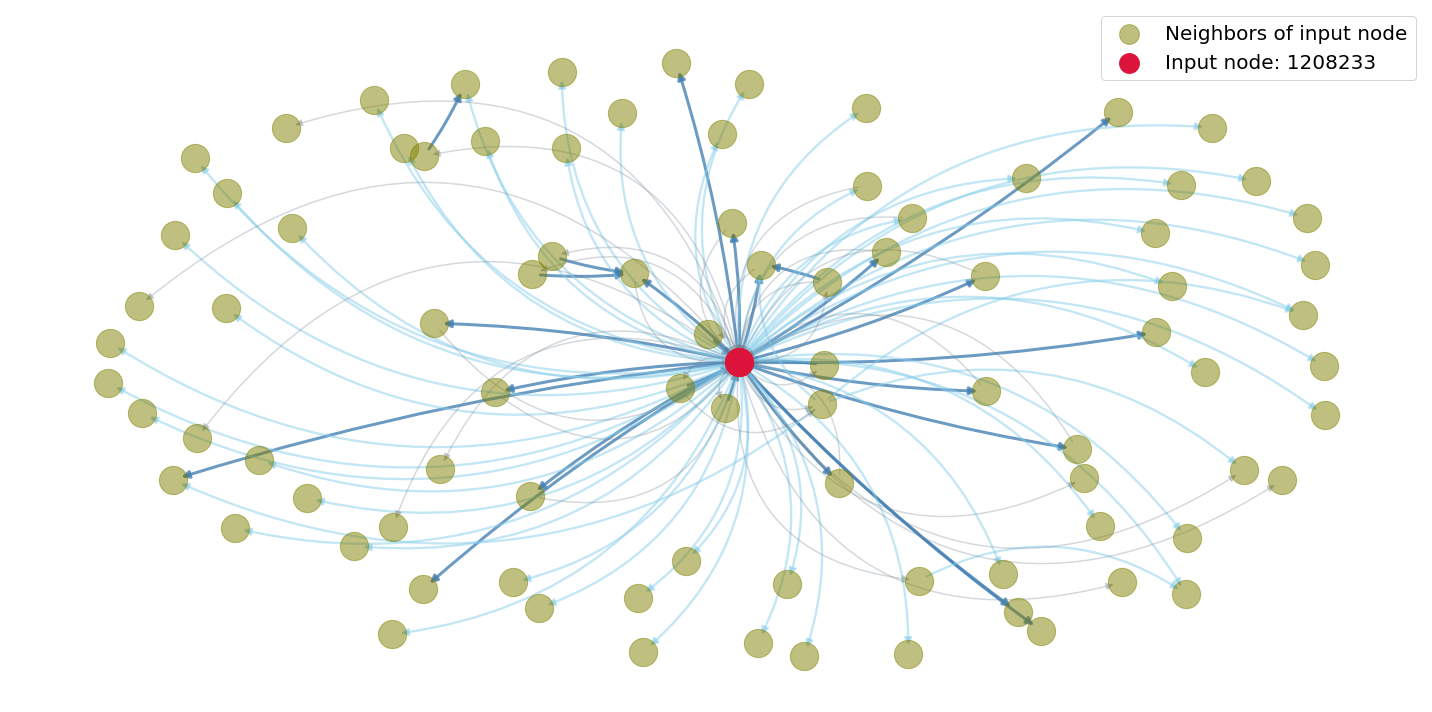

In [32]:
plot_subgraph(g.my_graph)

### Visualization 3 - Visualize the Shortest Ordered Route 

### Visualization 4 - Visualize disconnecting graphs 

## 4. Algorithmic question